In [47]:
# # read each file in datasets/Opportunity/by_subject:

# import os
# from matplotlib import pyplot as plt
# import pandas as pd
# import numpy as np

# directory = 'datasets/Opportunity/by_subject'
# csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# for file in csv_files:
#     # print(df.columns)
#     file_path = os.path.join(directory, file)
#     # Process the CSV file as needed
#     # For example, you can use pandas to read the CSV file:
#     df = pd.read_csv(file_path)
    
#     # print(df.to_numpy()[0:6])
#     # print(df.to_numpy()[:, 9])
    
#     # data statistics in plt:
#     print(np.unique(df['ML_Both_Arms']))
#     df['ML_Both_Arms'].plot(kind='hist', bins=18)
#     plt.show()


In [48]:
# read each file in datasets/Opportunity/by_subject:

import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

directory = 'raw_datasets/SPAR9X'
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

for file in csv_files:
    # print(df.columns)
    file_path = os.path.join(directory, file)
    # Process the CSV file as needed
    # For example, you can use pandas to read the CSV file:
    df = pd.read_csv(file_path)
    
    # print(df.to_numpy()[0:6])
    # print(df.to_numpy()[:, 9])
print(len(csv_files))


380


In [49]:

from utilities import *
sw = sliding_windows(100, 50)
X = []
Y = []


def replace_with_most_frequent(y):
    #NOTE: func used for OPPORTUNITY dataset by subject, if there are more than 1 label in a window, replace with the most frequent label
    # Iterate over each sample
    for i in range(y.size(0)):
        # Find unique labels and their counts
        unique_labels, counts = torch.unique(y[i], sorted=True, return_counts=True)
        # print(unique_labels, counts)
        if  len(unique_labels) > 1:
            # Find the most frequent label, exclude 0:
            most_frequent_label = unique_labels[1:][torch.argmax(counts[1:])]
            y[i] = most_frequent_label
    return y


for file in csv_files:
    # print(df.columns)
    file_path = os.path.join(directory, file)
    # Process the CSV file as needed
    # For example, you can use pandas to read the CSV file:
    df = pd.read_csv(file_path)
    # print(df.to_numpy().shape)
    x, _ = sw(torch.tensor(df.to_numpy()[:, [0,1,2,6,7,8]]), torch.tensor(df.to_numpy())) # sec para as placeholder, not used
    # divide the gravity by 9.81 on 0-2: 
    x[:, :, 0:3] = x[:, :, 0:3] / 9.81
    y = int(file.split('_')[1][1::]) - 1
    X.append(x)
    Y.extend([y] * x.size(0))

X = torch.cat(X, dim=0)
# Y = torch.cat(Y, dim=0)
Y = torch.tensor(Y)
X.shape, Y.shape

for i in range(10):
    print(torch.sum(Y == i))

tensor(1306)
tensor(1643)
tensor(1244)
tensor(1239)
tensor(1228)
tensor(1551)
tensor(1597)
tensor(1527)
tensor(1858)
tensor(1406)


In [50]:
from sklearn.discriminant_analysis import StandardScaler
import torch
from torch.utils.data import Dataset
from livelossplot import PlotLosses

class StandardTransform(torch.nn.Module):
    def __init__(self, scaler='standard'):
        super(StandardTransform, self).__init__()
        if scaler == 'standard':
            self.scaler = StandardScaler()
        else:
            raise NotImplementedError('Only standard scaler is implemented')
        
    def __call__(self, data):
        data = self.scaler.transform(data)
        return torch.tensor(data)
    
    def fit(self, data):
        n_samples, n_time_steps, n_features = data.shape
        data_reshaped = data.reshape(-1, n_features)  # The shape becomes (n_samples * n_time_steps, n_features)
        self.scaler.fit(data_reshaped)
        print('Fitted with mean: {}, and std: {}'.format(self.scaler.mean_, np.sqrt(self.scaler.var_)))
        return self


class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.X[index]), self.Y[index]
        return torch.tensor(self.X[index]), int(self.Y[index])

# Dataloader
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Split the dataset into train, valid, test sets:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)
# Initialize the StandardScaler
# ST = StandardTransform().fit(train_X)

ST = lambda x: x


# Create dataloaders for train and test sets
train_dataloader = DataLoader(MultivariateTimeSeriesDataset(train_X, train_Y, transform=ST), batch_size=32, shuffle=True)
val_dataloader = DataLoader(MultivariateTimeSeriesDataset(valid_X, valid_Y, transform=ST), batch_size=32, shuffle=False)
test_dataloader = DataLoader(MultivariateTimeSeriesDataset(test_X, test_Y, transform=ST), batch_size=32, shuffle=False)


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
from utilities import *
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
num_epochs = 100

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=6, hidden_size=1024, num_layers=2, output_size=18):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
import torch.nn.functional as F
import math 


    
class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken=6, ninp=64, nhead=1, nhid=256, nlayers=6, dropout=0.1, activation='relu'):
        super(TransformerModel, self).__init__()
        self.input_emb = nn.Linear(ntoken, ninp)
        self.ninp = ninp
        self.relu = nn.ReLU()
        encoder_layer = nn.TransformerEncoderLayer(d_model=ninp, nhead=nhead, dim_feedforward=nhid, dropout=dropout, activation=activation, batch_first=True)
        encoder_norm = nn.LayerNorm(ninp)   
        self.transformer_encoder = TransformerEncoder(encoder_layer, nlayers, norm=encoder_norm)
        self.decoder = nn.Linear(ninp, 1)
        # max layer:
        self.max = nn.MaxPool1d(100)
        self.psi = nn.Linear(100, 10)

    def forward(self, src):
        src = self.input_emb(src)
        src = self.relu(src)
        output = self.transformer_encoder(src)
        
        # max layer:
        # output = output.transpose(0, 1)
        # output = self.max(output)
        # output = output.transpose(1, 2)
        output = self.decoder(output)
        output = output.squeeze(-1)
        output = self.psi(output)
        
        return output
    
        # return F.sigmoid(output).squeeze(-1) # return F.log_softmax(output, dim=-1)

device = get_device()

MPS is available.


In [52]:
# # Create an instance of the CNN model
# model = TransformerModel().to(device)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# liveloss = PlotLosses()
# # Iterate over the training data
# logs = {}
# # change the plt size:
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_dataloader):
#         # Forward pass
#         images = images.float().to(device)
#         labels = labels.squeeze().long().to(device)
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         # train loss and accuracy check:
#         if i % 1000 == 0:
#             print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
#             _, predicted = torch.max(outputs.data, 1)
#             total = labels.size(0)
#             correct = (predicted == labels).sum().item()
#             # print('Accuracy: {:.2f}%'.format(correct / total * 100))
#             logs['loss'] = loss.item()
#             logs['accuracy'] = correct / total * 100
    
#             # validation loss and accuracy check:
#             correct = 0
#             total = 0
#             losses =  []
#             for images, labels in val_dataloader:
#                 images = images.float().to(device)
#                 labels = labels.squeeze().long().to(device)
#                 outputs = model(images)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
#                 losses.append(criterion(outputs, labels).item())
#             logs['val_loss'] = np.mean(losses)
#             logs['val_accuracy'] = correct / total * 100
#     liveloss.update(logs)
#     liveloss.send()

# # Evaluate the model on the test data
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in test_dataloader:
#         images = images.float().to(device)
#         labels = labels.squeeze().long().to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
    
#     accuracy = 100 * correct / total
#     print('Test Accuracy: {:.2f}%'.format(accuracy))


In [53]:
# torch.save(model.state_dict(), './saved_model/transformer_model.pth')

In [54]:
# model = TransformerModel().to(device)
# model.load_state_dict(torch.load('./saved_model/transformer_model.pth'))
# for i, (images, labels) in enumerate(train_dataloader):
#     # Forward pass
#     images = images.float().to(device)
#     labels = labels.squeeze().long().to(device)
#     outputs = model(images)
#     loss = criterion(outputs, labels)
#     reshaped_images = images.view(-1, 6)
#     pred = torch.argmax(outputs, dim=1)

#     plt.plot(reshaped_images.cpu().numpy(), color='black')
#     # for each pred, repeat it for 50 times: 
#     plt.plot(np.repeat(pred.cpu().numpy(), 50), color='green')
#     # for each label, do the same:
#     plt.plot(np.repeat(labels.cpu().numpy(), 50), color='red')
#     plt.show()
#     break
    
    
    
    
    

In [55]:
# !pip install easyfsl
from easyfsl.samplers import TaskSampler

In [56]:
def cosine_distance_to_prototypes(A, B) -> torch.Tensor:
        """
        Compute prediction logits from their cosine distance to support set prototypes.
        Args:
            samples: features of the items to classify of shape (n_samples, feature_dimension)
        Returns:
            prediction logits of shape (n_samples, n_classes)
        """
        return torch.nn.functional.normalize(A, p=2, dim=1) @ torch.nn.functional.normalize(B, p=2, dim=1).T
        

class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
        self.linear = nn.Linear(100, 100)
    def forward_segment(self, support):
        x = self.backbone(support)
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x
        
    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )
        # print(z_proto.shape, z_query.shape)

        # Compute the cosine distance from queries to prototypes:
        # dists = cosine_distance_to_prototypes(z_query, z_proto)
        dists = torch.cdist(z_query, z_proto)
        # print(dists.shape)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores
    

In [57]:
backbone_model = TransformerModel().to(device)
backbone_model.load_state_dict(torch.load('./saved_model/transformer_model.pth'))

backbone_model.psi = nn.Flatten()
prototype_model = PrototypicalNetworks(backbone_model).to(device)

/Users/davidwang/opt/anaconda3/envs/research/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [58]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100
test_set = MultivariateTimeSeriesDataset(test_X, test_Y, transform=ST)
# check each class has what number of samples:
# print(set(test_Y.tolist()))
test_set.get_labels = lambda: test_set.Y.tolist()

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    # num_workers=0,
    # pin_memory=False,
    collate_fn=test_sampler.episodic_collate_fn,
)
# next(iter(test_loader))

In [59]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

prototype_model.eval()
example_scores = prototype_model(
    example_support_images.float().to(device),
    example_support_labels.float().to(device),
    example_query_images.float().to(device),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set.Y[example_class_ids[example_query_labels[i]]]} / {test_set.Y[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
2 / 7
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
4 / 7
4 / 4
4 / 7
4 / 7
4 / 4
4 / 4
4 / 7
4 / 7
4 / 4
4 / 7
7 / 7
7 / 7
7 / 7
7 / 7
7 / 4
7 / 4
7 / 4
7 / 7
7 / 7
7 / 7


In [60]:
from tqdm import tqdm

In [61]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            prototype_model(support_images.float().to(device), support_labels.float().to(device), query_images.float().to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.float().to(device)
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    prototype_model.eval()
    with torch.no_grad():
        for episode_index, \
            (support_images, support_labels, query_images, query_labels, class_ids,)\
            in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:02<00:00, 42.53it/s]

Model tested on 100 tasks. Accuracy: 69.76%


(166, 6)


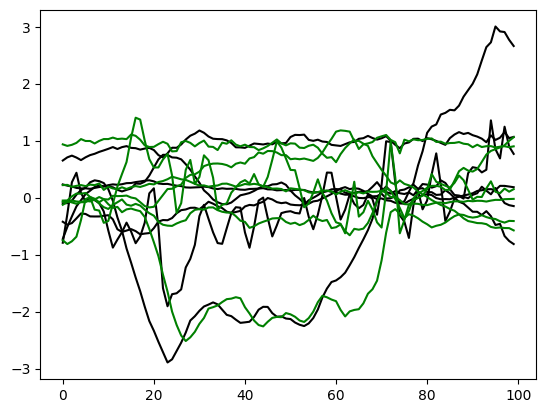

In [62]:
backbone_model = TransformerModel().to(device)
backbone_model.load_state_dict(torch.load('./saved_model/transformer_model.pth'))

backbone_model.psi = nn.Flatten()
prototype_model = PrototypicalNetworks(backbone_model).to(device)
# extract a sample from 1-rep sample using the same dataset spar9x:
filename = "datasets/spar/S20_E4_L_5.csv"
sample = pd.read_csv(filename).to_numpy()[:, 1:7]
print(sample.shape)
filename = 'raw_datasets/SPAR/S1_E4_L.csv'
positive_sample = pd.read_csv(filename).to_numpy()[:, :] # [0,1,2,6,7,8]
# positive_sample[ :, 0:3] = positive_sample[ :, 0:3] / 9.81
filename = 'raw_datasets/SPAR/S1_E2_R.csv'
negative_sample = pd.read_csv(filename).to_numpy()[:, :]
# negative_sample[ :, 0:3] = negative_sample[ :, 0:3] / 9.81
plt.plot(positive_sample[0:100], color='black')
plt.plot(sample[0:100], color='green')
# plt.plot(negative_sample, color='red')
plt.show()





torch.Size([166, 6])


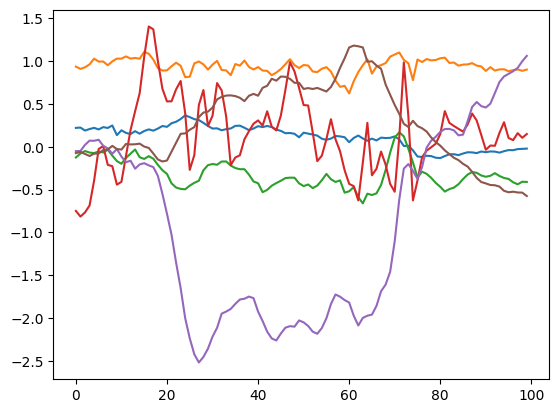

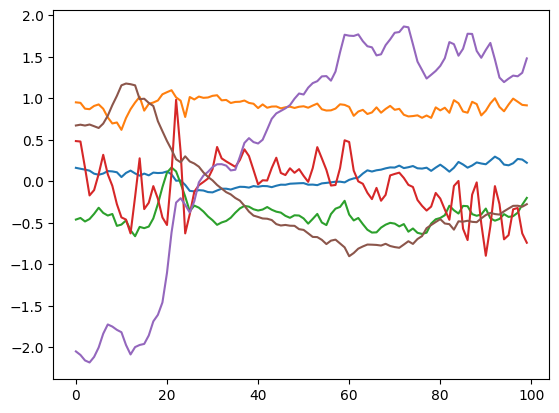

torch.Size([2, 100, 6])

In [63]:
sample = torch.tensor(sample)
print(sample.shape)
segmented_sample,_  = sw.forward(sample, sample) 

for i in range(segmented_sample.shape[0]):
    plt.plot(segmented_sample[i])
    plt.show()

sample_dl = DataLoader(MultivariateTimeSeriesDataset(segmented_sample, [5] * segmented_sample.shape[0], transform=ST), batch_size=1, shuffle=False)

positive_sample = torch.tensor(positive_sample)
positive_segmented_sample,_  = sw.forward(positive_sample, positive_sample) 
pos_sample_dl = DataLoader(MultivariateTimeSeriesDataset(positive_segmented_sample, [5] *positive_segmented_sample.shape[0], transform=ST), batch_size=1, shuffle=False)

negative_sample = torch.tensor(negative_sample)
negative_segmented_sample,_  = sw.forward(negative_sample, negative_sample)
neg_sample_dl = DataLoader(MultivariateTimeSeriesDataset(negative_segmented_sample, [6]*negative_segmented_sample.shape[0], transform=ST), batch_size=1, shuffle=False)
segmented_sample.shape

In [64]:
inp,target = next(iter(sample_dl))

pos_output = prototype_model.backbone(inp.float().to(device))

In [65]:
# loss: ce + shannon + kl:
CE = nn.MSELoss()
optimizer = optim.Adam(prototype_model.linear.parameters(), lr=0.1)

for data, _ in sample_dl:
    output = prototype_model.backbone(data.float().to(device))
    output = prototype_model.linear(output)
    output = torch.sigmoid(output)
    label = torch.ones_like(output)
    pred = torch.where(output > 0.5, torch.ones_like(output), torch.zeros_like(output))
    loss = CE(output, label)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())

    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    # print(loss.item())
    

0.3233690857887268
0.0


tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='mps:0')


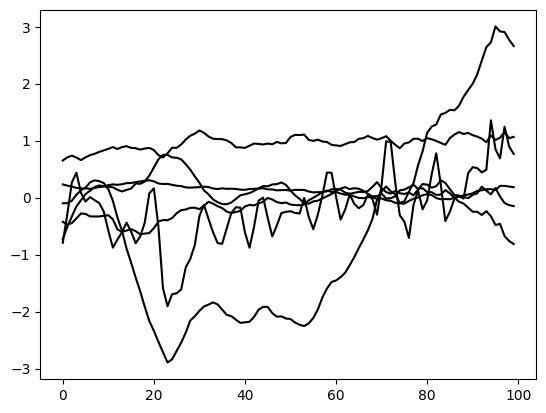

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='mps:0')


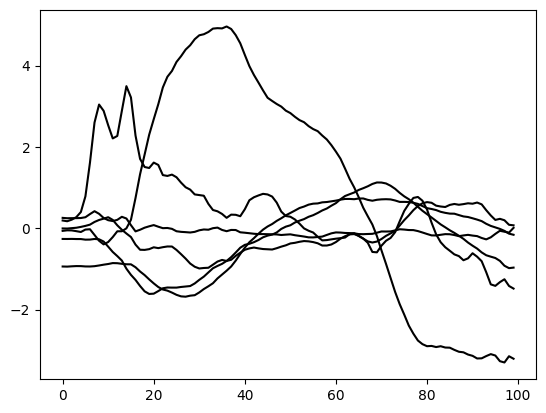

In [66]:
for data, _ in pos_sample_dl:
    output = prototype_model.backbone(data.float().to(device))
    output = prototype_model.linear(output)
    output = torch.sigmoid(output)
    pred = torch.where(output > 0.5, torch.ones_like(output), torch.zeros_like(output))
    print(pred)
    plt.plot(data.view(-1, 6).cpu().numpy(), color='black')
    plt.plot(pred.cpu().numpy(), color='green')
    plt.show()
    break 

for data, _ in neg_sample_dl:
    output = prototype_model.backbone(data.float().to(device))
    output = prototype_model.linear(output)
    output = torch.sigmoid(output)
    pred = torch.where(output > 0.5, torch.ones_like(output), torch.zeros_like(output))
    print(pred)
    plt.plot(data.view(-1, 6).cpu().numpy(), color='black')
    plt.plot(pred.cpu().numpy(), color='green')
    plt.show()
    break 
    

# Attempt to synethesize one-rep segment into larger one and recognize the particular "pattern" in this large segment:

In [67]:
import os
import random
import pandas as pd

def list_files(directory):
    return [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

def parse_filename(filename):
    parts = filename.split('_')
    return {'subject': parts[0], 'exercise': parts[1], 'hand': parts[2], 'rep': int(parts[3].split('.')[0])}

def group_files(files):
    groups = {}
    for file in files:
        info = parse_filename(file)
        key = (info['subject'], info['hand'])
        if key not in groups:
            groups[key] = []
        groups[key].append(file)
    return groups

def generate_combinations(group, combo, num_results):
    all_exercises = list(set(f.split('_')[1] for f in group))
    combinations = []
    labels = []
    for _ in range(num_results):
        # Determine a random length for the combination
        combo_length = len(combo)
        max_length = max(combo_length * 3, len(all_exercises))
        random_length = random.randint(combo_length, max_length)
        # Create a random combination of exercises
        random_exercises = random.choices(all_exercises, k=random_length)
        random_labels = [0] * len(random_exercises)
        # Insert the combo at a random position
        #NOTE: currently it is only insert once.
        insert_point = random.randint(0, len(random_exercises) - combo_length)
        for i, exercise in enumerate(combo):
            random_exercises.insert(insert_point + i, exercise)
            random_labels.insert(insert_point +i , 1)
        combinations.append(random_exercises)
        labels.append(random_labels)

    return combinations, labels


def concatenate_data(directory, group, order, label=None):
    concatenated_df = pd.DataFrame()
    concatenated_label = []
    for i, exercise in enumerate(order):
        matching_files = [f for f in group if f.split('_')[1] == exercise]
        file = matching_files[random.randint(0, len(matching_files))-1] # randomly pick one file 
        df = pd.read_csv(os.path.join(directory, file))
        concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)
        if label != None:
            concatenated_label.extend([label[i]] * len(df))
    return concatenated_df.to_numpy()[:, 1:7], np.array(concatenated_label)


TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [122]:
backbone_model = TransformerModel().to(device)
backbone_model.load_state_dict(torch.load('./saved_model/transformer_model.pth'))

backbone_model.psi = nn.Flatten()
prototype_model = PrototypicalNetworks(backbone_model).to(device)


def custom_loss(input, output, label):
    CE = nn.BCELoss()
    # Shannon entropy:
    bce = CE(output, label)
    # print(output)
    shannon = -torch.mean(torch.sum(output * torch.log(output), dim=1))
    # KL divergence:
    # kl = kl_divergence(input.view(-1).cpu().numpy(), output.view(-1).cpu().numpy(), label.view(-1).cpu().numpy())
    print(bce.item(), shannon.item())
    return .9 * bce + 0.1 * shannon

directory = './datasets/spar9x/'
combo = ['E6', 'E6', 'E6', 'E6']
num_results = 5  # Number of random combinations to generate
files = list_files(directory)
groups = group_files(files)
# randomly pick one group from the dic:
key = random.choice(list(groups.keys()))
group = groups[key]
combinations,labels = generate_combinations(group, combo, num_results)
# print(combinations)


segmented_samples = []
segmented_labels = []
for i, (order, label) in enumerate(zip(combinations, labels)):
    # print('length', len(order), order, label)
    concatenated_np, concat_label = concatenate_data(directory, group, order, label=label)
    
    conc_data = torch.tensor(concatenated_np)
    conc_label = torch.tensor(concat_label)
    
    segmented_sample, segmneted_label  = sw.forward(conc_data, conc_label)
    segmented_samples.append(segmented_sample)
    segmented_labels.append(segmneted_label)

segmented_samples = torch.cat(segmented_samples)
segmented_labels = torch.cat(segmented_labels)
for _ in range(5):
    for data, label in zip(segmented_samples, segmented_labels):
        data = data.unsqueeze(0)
        label = label.unsqueeze(0).float().to(device)
        output = prototype_model.backbone(data.float().to(device))
        output = prototype_model.linear(output)
        output = torch.sigmoid(output)
        # output = torch.softmax(output, dim=1)
        # pred = torch.where(output > 0.5, torch.ones_like(output), torch.zeros_like(output))
    
    
    
     

    # sample_dl = DataLoader(MultivariateTimeSeriesDataset(segmented_sample, [5] * segmented_sample.shape[0], transform=ST), batch_size=1, shuffle=False)


/Users/davidwang/opt/anaconda3/envs/research/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


2.3384246826171875 13.404169082641602
3.4449989795684814
1.5277636051177979 15.196617126464844
2.894649028778076
1.3882306814193726 18.917678833007812
3.1411752700805664
2.478010892868042 10.457021713256836
3.275912046432495
1.7256227731704712 12.12170124053955
2.765230655670166
2.318251848220825 11.45809555053711
3.232235908508301
1.1381933689117432 15.65953540802002
2.590327739715576
1.6563574075698853 13.838403701782227
2.8745620250701904
1.4898048639297485 15.751216888427734
2.9159460067749023
3.6860857009887695 9.906466484069824
4.308123588562012
2.7881321907043457 7.960930824279785
3.3054118156433105
2.4205331802368164 12.983200073242188
3.476799964904785
2.0055580139160156 15.341217041015625
3.3391239643096924
3.1629250049591064 10.722038269042969
3.9188363552093506
1.5661965608596802 12.44015121459961
2.653592109680176
1.0772349834442139 13.044490814208984
2.273960590362549
0.721464216709137 12.00057601928711
1.8493754863739014
1.9106370210647583 9.08359146118164
2.627932548522

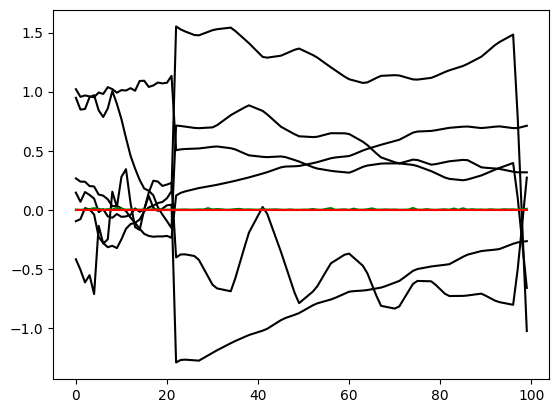

KeyboardInterrupt: 

In [123]:
import time
from IPython.display import display, clear_output

directory = './datasets/spar9x/'
combo = ['E6', 'E6', 'E6', 'E6']
num_results = 5  # Number of random combinations to generate
files = list_files(directory)
groups = group_files(files)
# randomly pick one group from the dic:
key = random.choice(list(groups.keys()))
group = groups[key]
combinations,labels = generate_combinations(group, combo, num_results)
# print(combinations)

segmented_samples = []
segmented_labels = []
for i, (order, label) in enumerate(zip(combinations, labels)):
    # print('length', len(order), order, label)
    concatenated_np, concat_label = concatenate_data(directory, group, order, label=label)
    
    conc_data = torch.tensor(concatenated_np)
    conc_label = torch.tensor(concat_label)
    
    segmented_sample, segmneted_label  = sw.forward(conc_data, conc_label)
    segmented_samples.append(segmented_sample)
    segmented_labels.append(segmneted_label)

segmented_samples = torch.cat(segmented_samples)
segmented_labels = torch.cat(segmented_labels)
    
for data, label in zip(segmented_samples, segmented_labels):
    data = data.unsqueeze(0)
    label = label.unsqueeze(0).float().to(device)
    output = prototype_model.backbone(data.float().to(device))
    output = prototype_model.linear(output)
    output = torch.sigmoid(output)
    # output = torch.softmax(output, dim=1)
    # pred = torch.where(output > 0.5, torch.ones_like(output), torch.zeros_like(output))
    plt.plot(data.view(-1, 6).cpu().numpy(), color='black')
    plt.plot(output.detach().squeeze().cpu().numpy(), color='green')
    plt.plot(label.view(-1).cpu().numpy(), color='red')
    plt.show()
    # wait for 1 sec:
    time.sleep(1)
    # erase the output:
    clear_output(wait=True)
    
    